<a href="https://colab.research.google.com/github/JinHuiXu1991/Jin_DATA606/blob/main/ipynb/DATA606_Part2_ContentBasedFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Recommender Systems
## Author: Jin Hui Xu

##Content Based Filtering 

In [1]:
!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true

!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_review.zip?raw=true

--2022-03-20 20:04:43--  https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-03-20 20:04:44--  https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-03-20 20:04:44--  https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.

In [226]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import time
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Description Based Recommender (Cosine Similarity)

In [3]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

In [4]:
product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",NaN,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,NaN,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,NaN,the cigar moments of pleasure,the cigar book,NaN,amazon home,NaN,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,NaN,tools home improvement,2014-12-17,NaN,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


In [5]:
product_df.shape

(30239, 13)

In [6]:
# Replace all NaN with an empty string
product_df = product_df.fillna('')
product_df.isnull().sum()

category           0
description        0
title              0
brand              0
feature            0
main_cat           0
date               0
price              0
asin               0
imageURLHighRes    0
dateYear           0
dateMonth          0
ori_title          0
dtype: int64

In [45]:
stop = stopwords.words('english')

In [7]:
lem = WordNetLemmatizer()
def lemma(text):
    return ' '.join(lem.lemmatize(w) for w in text.split() if w not in stop)   

In [8]:
product_df['description'] = product_df['description'].apply(lemma)

In [9]:
# Define a TF-IDF Vectorizer object and remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english', max_df = 0.9, min_df = 5)

In [10]:
# Construct the required TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(product_df['description'])

In [11]:
# Output the shape of tfidf_matrix
tfidf_matrix.shape

(30239, 9738)

Both linear_kernel and cosine_similarity methods produce the same result. We would like to apply both methods can see the performance of creating the cosine similarity matrix, and choose the faster one.

In [12]:
start = time.time()
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print("Time taken: %s seconds" % (time.time() - start))

Time taken: 14.88059139251709 seconds


In [13]:
# start = time.time()
# cosine_sim2 = cosine_similarity(tfidf_matrix, tfidf_matrix)
# print("Time taken: %s seconds" % (time.time() - start))

The performance results are very close, and the linear_kernel result will be used

In [14]:
# Reverse mapping of indices and product id
indices = pd.Series(product_df.index, index=product_df['asin'].str.lower()).drop_duplicates()

In [15]:
# Function that takes in product id as input and gives recommendations 
def description_recommender(id, cosine_sim = cosine_sim, df = product_df, indices = indices):
  # get the index of the product that matches the id
  idx = indices[id.lower()]

  # get the pairwsie similarity scores 
  # then convert it into a list of tuples as described above
  sim_scores = list(enumerate(cosine_sim[idx]))

  # sort the product based on the cosine similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # get the scores of the 10 most similar product. Ignore the first one because it is the input product.
  sim_scores = sim_scores[1:11]

  # get the product indices
  product_indices = [i[0] for i in sim_scores]

  # return the top 10 most similar product
  return df['asin'].iloc[product_indices].tolist(), df['ori_title'].iloc[product_indices].tolist()

In [16]:
product_df[product_df['title'].str.contains('refrigerator', case=False)].head(1)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
131,"Appliances Refrigerators, Freezers & Ice Makers",compact mini cooler warmer hold 17 liter twent...,coldmate mr 128 mini cooler warmer deluxe mini...,coldmate,press the cold button to cool to 40 f and hot ...,appliances,2001-10-02,,B0001YH10C,['https://images-na.ssl-images-amazon.com/imag...,2001,10,Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini...


In [17]:
# get input id and title for the recommendation
input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['asin']
input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['title']

In [18]:
#Get recommendations for Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini Refrigerator, input the product id 
asin, title = description_recommender(input_id)

In [19]:
print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
for i in range(0, 10):
  print('{}. {}, {}'.format(i+1, asin[i], title[i]))

Description Based Recommender Result for B0001YH10C, coldmate mr 128 mini cooler warmer deluxe mini refrigerator: 
1. B00ID8CLMG, Avanti FF45006W 4.3 CF Frost Free Refrigerator Freezer, White
2. B00RNAH5OY, goFridge Mini Fridge Portable Electric Cooler
3. B001H80RN4, Frigidaire 241505301 Refrigerator Door Bin Genuine Original Equipment Manufacturer (OEM) Part
4. B004NEYPYQ, Frost-Free 4.3 Cu. Ft. Refrigerator/Freezer White
5. B000JLL3BK, Pek Vino Vault Wine Preserving Refrigerator, Silver
6. B01F79MKME, Amana AMA43BK Compact Single Door Refrigerator, 4.3 cu. ft, Black
7. B001F7H4RY, PORTABLE COOLER WARMER MINI FRIDGE WINE BEER
8. B001AAHW6E, Whirlpool 2179404KRA Beverage Rack
9. B001775T4C, Nostalgia Electrics CRF170RETRORED Retro Series Mini Fridge, 1.7 Cubic Feet
10. B004Y3C9J4, 1.7 cuft Superconduction Refrigerator


In [20]:
# np.save('cosine_sim', cosine_sim)

In [21]:
# original_cs = np.load("cosine_sim.npy")
# original_cs

In [22]:
# get input id and title for the recommendation
# input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[1]['asin']
# input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[1]['title']

In [23]:
#Get recommendations
# asin, title = description_recommender(input_id, cosine_sim=original_cs)

In [24]:
# print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
# for i in range(0, 10):
#   print('{}. {}, {}'.format(i+1, asin[i], title[i]))

### Metadata Based Recommender (Cosine Similarity)

In [25]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
product_df = product_df.fillna('')

In [26]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30239 entries, 0 to 30238
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         30239 non-null  object
 1   description      30239 non-null  object
 2   title            30239 non-null  object
 3   brand            30239 non-null  object
 4   feature          30239 non-null  object
 5   main_cat         30239 non-null  object
 6   date             30239 non-null  object
 7   price            30239 non-null  object
 8   asin             30239 non-null  object
 9   imageURLHighRes  30239 non-null  object
 10  dateYear         30239 non-null  int64 
 11  dateMonth        30239 non-null  int64 
 12  ori_title        30239 non-null  object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [27]:
# Use meta data except description and features
product_df['meta_text'] = product_df['category'] + ' ' +  product_df['title'] + ' ' +  product_df['brand'] + ' ' + product_df['main_cat'] + ' ' + product_df['price'].astype(str) + ' ' + product_df['dateYear'].astype(str) + ' ' + product_df['dateMonth'].astype(str) 
product_df['meta_text'] = product_df['meta_text'].apply(lemma)

In [28]:
# Define a TF-IDF Vectorizer object and remove all english stopwords
tfidf2 = TfidfVectorizer(stop_words='english', max_df = 0.9, min_df = 5)

In [29]:
tfidf_matrix2 = tfidf2.fit_transform(product_df['meta_text'])

In [30]:
tfidf_matrix2.shape

(30239, 3381)

In [31]:
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [32]:
indices = pd.Series(product_df.index, index=product_df['asin'].str.lower()).drop_duplicates()

In [33]:
# Function that takes in product id as input and gives recommendations 
def description_recommender(id, cosine_sim = cosine_sim2, df = product_df, indices = indices):
  # get the index of the product that matches the id
  idx = indices[id.lower()]

  # get the pairwsie similarity scores 
  # then convert it into a list of tuples as described above
  sim_scores = list(enumerate(cosine_sim[idx]))

  # sort the product based on the cosine similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # get the scores of the 10 most similar product. Ignore the first one because it is the input product.
  sim_scores = sim_scores[1:11]

  # get the product indices
  product_indices = [i[0] for i in sim_scores]

  # return the top 10 most similar product
  return df['asin'].iloc[product_indices].tolist(), df['ori_title'].iloc[product_indices].tolist()

In [34]:
product_df[product_df['title'].str.contains('refrigerator', case=False)].head(1)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title,meta_text
131,"Appliances Refrigerators, Freezers & Ice Makers",this compact mini cooler and warmer holds 17 l...,coldmate mr 128 mini cooler warmer deluxe mini...,coldmate,press the cold button to cool to 40 f and hot ...,appliances,2001-10-02,,B0001YH10C,['https://images-na.ssl-images-amazon.com/imag...,2001,10,Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini...,"Appliances Refrigerators, Freezers & Ice Maker..."


In [35]:
# get input id and title for the recommendation
input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['asin']
input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['title']

In [36]:
#Get recommendations
asin2, title2 = description_recommender(input_id, cosine_sim=cosine_sim2)

In [37]:
print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
for i in range(0, 10):
  print('{}. {}, {}'.format(i+1, asin2[i], title2[i]))

Description Based Recommender Result for B0001YH10C, coldmate mr 128 mini cooler warmer deluxe mini refrigerator: 
1. B001F7H4RY, PORTABLE COOLER WARMER MINI FRIDGE WINE BEER
2. B00YNNEC8Q, Mini Wine Cooler
3. B00YNMUYV6, Mini Wine Cooler Refrigerator with Lock
4. B00ND5CWAA, Phoenix USB 5v Portable One Zip-top Can Cooler-mini Car Compact Refrigerator and Warmer
5. B00RNAH5OY, goFridge Mini Fridge Portable Electric Cooler
6. B016K4J3U2, Honeykoko Mini USB PC Refrigerator Fridge Beverage Drink Can Cooler Warmer Heater Gadget One Can in Home Office
7. B016KQ7X8E, ThreeH New Mini Red USB Fridge Cooler Beverage Drink Cans Cooler/Warmer Refrigerator for Laptop PC Computer Red H-UF05Red
8. B0187KYRQC, Coca-Cola Mini Can Cooler
9. B00KE7FM3O, Mini USB Desktop Fridge Cooler Refrigerator
10. B00YACMRIM, Neon&reg; Mini USB PC Refrigerator Fridge Beverage Drink Can Cooler Warmer Heater Gadget with Fake LCD Display Function


### Topic Modeling Recommender (LDA)

In [232]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
product_df = product_df.fillna('')

In [233]:
product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,,the cigar moments of pleasure,the cigar book,,amazon home,,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,,tools home improvement,2014-12-17,,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


In [234]:
product_df['all_text'] = product_df['category'] + ' ' + product_df['description'] + ' ' + product_df['title'] + ' ' + product_df['brand'] + ' ' + product_df['feature'] +\
                         product_df['main_cat']

In [235]:

words = set(nltk.corpus.words.words())
def clear_text(doc):
  soup = BeautifulSoup(doc)
  cleaned_text = soup.get_text()
  #cleaned_text = " ".join(w for w in nltk.wordpunct_tokenize(cleaned_text) if w.lower() in words or not w.isalpha())
  cleaned_text = re.sub('[^a-zA-Z0-9]', ' ', cleaned_text)
  cleaned_text = re.sub('\s\s+', ' ', cleaned_text)
  cleaned_text = cleaned_text.lower()
  return cleaned_text

In [236]:
product_df['all_text'] = product_df['all_text'].apply(clear_text)

In [237]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(product_df['all_text']))

In [238]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop] for doc in texts]

In [239]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [240]:
lem = WordNetLemmatizer()
def lemma(texts):
    return [[lem.lemmatize(w) for w in simple_preprocess(str(doc))] for doc in texts]

In [241]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization
data_lemmatized = lemma(data_words_bigrams)
data_lemmatized[0]

['ice',
 'freezer',
 'square',
 'round',
 'container',
 'set',
 'set',
 'two',
 'cup',
 'one',
 'cup',
 'use',
 'keep',
 'sandwich',
 'fresh',
 'refrigerator',
 'gently',
 'twist',
 'container',
 'pop',
 'frozen',
 'dishwasher_safe',
 'set',
 'le']

Create the two main inputs for the LDA topic model: the dictionary(id2word) and the corpus. 

In [242]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [243]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [244]:
# Iterate over possible number of topics.
topic_param = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,1,0.365570
1,2,0.469751
2,3,0.549681
3,4,0.555160
4,5,0.583055
5,6,0.558670
6,7,0.503020
7,8,0.588805
8,9,0.604291
9,10,0.606212


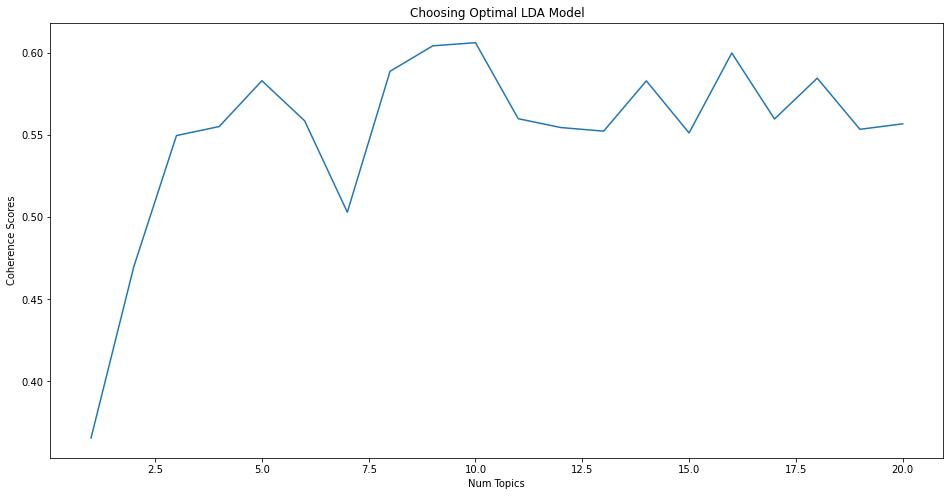

In [245]:
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [246]:
# Build LDA model
k=10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [247]:
lda_model.print_topics()

[(0,
  '0.178*"part" + 0.100*"ge" + 0.086*"brand" + 0.064*"authorized" + 0.062*"various" + 0.040*"product" + 0.039*"number" + 0.022*"p" + 0.019*"factory" + 0.017*"improvement"'),
 (1,
  '0.133*"quot" + 0.040*"span" + 0.032*"span_class" + 0.030*"input_type" + 0.023*"hidden_name" + 0.019*"wb" + 0.017*"class_icon" + 0.015*"name" + 0.015*"value" + 0.014*"class_button"'),
 (2,
  '0.046*"ice" + 0.036*"refrigerator" + 0.032*"door" + 0.019*"freezer" + 0.015*"ice_maker" + 0.012*"glass" + 0.010*"handle" + 0.009*"storage" + 0.009*"capacity" + 0.009*"food"'),
 (3,
  '0.014*"temperature" + 0.013*"easy" + 0.012*"use" + 0.010*"one" + 0.009*"time" + 0.008*"new" + 0.008*"humidity" + 0.008*"size" + 0.007*"made" + 0.007*"home"'),
 (4,
  '0.111*"water" + 0.085*"filter" + 0.040*"refrigerator" + 0.040*"replacement" + 0.019*"air" + 0.018*"compatible" + 0.018*"product" + 0.014*"humidifier" + 0.013*"pack" + 0.012*"certified"'),
 (5,
  '0.033*"stainless_steel" + 0.031*"range_hood" + 0.016*"inch" + 0.015*"speed"

In [248]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6019663382792829


In [249]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [250]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(product_df)):
  get_document_topics = lda_model.get_document_topics(corpus[n])
  doc_num.append(n)
  sorted_doc_topics = Sort_Tuple(get_document_topics)
  topic_num.append(sorted_doc_topics[0][0])
  prob.append(sorted_doc_topics[0][1])
product_df['Doc'] = doc_num
product_df['Topic'] = topic_num
product_df['Probability'] = prob


In [251]:
product_df

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title,all_text,Doc,Topic,Probability
0,"Appliances Refrigerators, Freezers & Ice Makers",,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...,ice freezer square round container set of 6 e...,0,3,0.388930
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...,ice 2 x pure fresh unique covered cool ice tr...,1,2,0.674470
2,Appliances Parts & Accessories,,the cigar moments of pleasure,the cigar book,,amazon home,,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure,the cigar of pleasure the cigar book home,2,6,0.560310
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,,tools home improvement,2014-12-17,,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene,especially to washing and can also be used fo...,3,3,0.809065
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,range plug full gauge and size beveled edge f...,4,5,0.445263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30234,Appliances Parts & Accessories,this is an authorized aftermarket product fits...,bosch 00175338 switch,bosch,this is an o e m authorized part fits with var...,tools home improvement,2016-06-25,40.23,B01HJH92JQ,[],2016,6,Bosch 00175338 Switch,this is an authorized product with various bo...,30234,0,0.649453
30235,Appliances Parts & Accessories,this is an authorized aftermarket product fits...,bosch 00478807 panel facia,bosch,this is an o e m authorized part fits with var...,tools home improvement,2010-03-03,95.99,B01HJH2I5G,['https://images-na.ssl-images-amazon.com/imag...,2010,3,Bosch 00478807 Panel-Facia,this is an authorized product with various bo...,30235,0,0.665370
30236,Appliances Parts & Accessories,this is an authorized aftermarket product fits...,bosch 00649288 ice maker,bosch,this is an o e m authorized part fits with var...,tools home improvement,2016-06-25,250.79,B01HJH0J1G,[],2016,6,Bosch 00649288 Ice Maker,this is an authorized product with various bo...,30236,0,0.609090
30237,Appliances Parts & Accessories Range Parts & A...,this is an o e m authorized part fits with var...,frigidaire 316543810 knob,frigidaire,this is an o e m authorized part fits with var...,tools home improvement,2016-06-25,14.99,B01HJHHEA0,['https://images-na.ssl-images-amazon.com/imag...,2016,6,Frigidaire 316543810 Knob,range this is an o e m authorized part with v...,30237,0,0.835164


In [252]:
def topic_modeling_recommender(title, df):
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended

In [253]:
topic_modeling_recommender("coldmate mr 128 mini cooler warmer deluxe mini refrigerator", product_df)

['Refrigerator Dispenser Door Flap Flapper New Oem Ge',
 'Wine Bouquet Kit Professional',
 'Whirlpool Reg 33 Inch Wide Top Freezer Refrigerator With Optional Ez Connect Icemaker Kit 20 5 Cu Ft',
 'Avallon Abr151Sgrh 86 Can 15 Quot Built In Beverage Cooler Right Hinge',
 'Frigidaire Gallery Stainless Steel Refrigerator Freezer Combo Amp Trim Fgru19F6Qf Fgfu19F6Qf Trimkitez2',
 'Rca Frf472 Chest Freezer 7 1 Cubic Feet White',
 'Frigidaire 242015101 Nameplate Label For Refrigerator',
 'Magic Chef Replacement Refrigerator Freezer Ice Maker 62577 5',
 'Delfield 3978279 Refrigerator Freezer Wire Shelf',
 'Scotsman Ice Systems A09543 000 Spinner Jet Fc01']

In [254]:
product_df.to_csv("Content_based_LDA_output.csv", index=False)